# Добрый день!

# Представляю проект - Определение стоимости автомобилей

# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Критерии, которые важны заказчику:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

**Целевой признак - `Price` — цена (евро)**


**Признаки**

•	`DateCrawled` — дата скачивания анкеты из базы

•	`VehicleType` — тип автомобильного кузова

•	`RegistrationYear` — год регистрации автомобиля

•	`Gearbox` — тип коробки передач

•	`Power` — мощность (л. с.)

•	`Model` — модель автомобиля

•	`Kilometer` — пробег (км)

•	`RegistrationMonth` — месяц регистрации автомобиля

•	`FuelType` — тип топлива

•	`Brand` — марка автомобиля

•	`Repaired` — была машина в ремонте или нет

•	`DateCreated` — дата создания анкеты

•	`NumberOfPictures` — количество фотографий автомобиля

•	`PostalCode` — почтовый индекс владельца анкеты (пользователя)

•	`LastSeen` — дата последней активности пользователя


## Загрузка данных и библиотек

In [ ]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings
import math


from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder,
                                   LabelEncoder)

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

# загрузка Phi_K

!pip install phik -q
import phik
from phik.report import plot_correlation_matrix
from phik import report


In [ ]:
# чтение и загрузка файла - основной датасет

auto = pd.read_csv('/datasets/autos.csv', sep=',', decimal = '.')
display(auto.head())
auto.shape

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


(354369, 16)

## Предобработка данных

**Явные дубликаты**

In [ ]:
# проверяем форматы данных

auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Данные загружены: всего  354 369 строк и 16 столбцов. Видим, что имеются пропуски в данных, которые будут отработаны на дальнейших этапах.**

**Форматы признаков определены верно**

In [ ]:
# проверяем пропуски в таблице

auto.isna().sum().sort_values(ascending=False)

Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**В таблицах есть значительные пропуски. Далее их заполним в пайплайне**

In [ ]:
# проверяем на дубликаты

auto.duplicated().sum()

4

In [ ]:
# обнаружено 4 дубликата, посмотрим эти строки подробно
duplicate_auto= auto[auto.duplicated()]
display(duplicate_auto)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [ ]:
# удалим явные дубликаты. 4 строки для всего датасета влияние минимально
auto = auto.drop_duplicates()

In [ ]:
auto.shape

(354365, 16)

**Неявные дубликаты**

In [ ]:
# проверка не неявные дубликаты

for column in auto.columns:
    print("Значения в столбце '", column,"':", auto[column].sort_values(ascending=False).unique(), '\n')

Значения в столбце ' DateCrawled ': ['2016-04-07 14:36:58' '2016-04-07 14:36:56' '2016-04-07 14:36:55' ...
 '2016-03-05 14:06:24' '2016-03-05 14:06:23' '2016-03-05 14:06:22'] 

Значения в столбце ' Price ': [20000 19999 19998 ...     2     1     0] 

Значения в столбце ' VehicleType ': ['wagon' 'suv' 'small' 'sedan' 'other' 'coupe' 'convertible' 'bus' nan] 

Значения в столбце ' RegistrationYear ': [9999 9996 9450 9229 9000 8888 8500 8455 8200 8000 7800 7500 7100 7000
 6500 6000 5911 5900 5600 5555 5300 5000 4800 4500 4100 4000 3800 3700
 3500 3200 3000 2900 2800 2500 2290 2222 2200 2066 2019 2018 2017 2016
 2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2002
 2001 2000 1999 1998 1997 1996 1995 1994 1993 1992 1991 1990 1989 1988
 1987 1986 1985 1984 1983 1982 1981 1980 1979 1978 1977 1976 1975 1974
 1973 1972 1971 1970 1969 1968 1967 1966 1965 1964 1963 1962 1961 1960
 1959 1958 1957 1956 1955 1954 1953 1952 1951 1950 1949 1948 1947 1946
 1945 1944 1943 1942 1941 1940

**Обнаружены странные несоотвествия значений в столбце:**

* `RegistrationYear` - с 9999 годы по 2066 и с 1800 по 1000 года (далее рассмотрим эти строки подробно)

* `Power` - странное обозначение 4/5-значного размера мощности автомобиля в лошадиных силах, а также слишком низких значений (менее 100), ниже будем более подробно рассматривать эти строки

* `NumberOfPictures` - все значения равны 0, значит этот столбец вообще можно удалить

In [ ]:
# посмотрим на строки, в которых `RegistrationYear` показывает странные значения

# сделаем необходимую выборку
auto_year = auto.query('RegistrationYear >= 2066 or RegistrationYear <= 1800')
display(auto_year.head())


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
12946,2016-03-29 18:39:40,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,2016-03-29 00:00:00,0,74523,2016-04-06 04:16:14
15147,2016-03-14 00:52:02,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-13 00:00:00,0,32689,2016-03-21 23:46:46
15870,2016-04-02 11:55:48,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-04-02 00:00:00,0,33649,2016-04-06 09:46:13
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58


In [ ]:
display(auto_year['RegistrationYear'].value_counts())

1000    37
9999    26
5000    17
3000     7
6000     5
1500     5
1800     5
2500     4
1234     4
7000     4
1111     3
4000     3
9000     3
5555     2
4500     2
1600     2
2222     2
8000     2
2800     2
5911     2
1300     2
5600     1
3800     1
1001     1
1253     1
1255     1
1039     1
4800     1
2290     1
7100     1
8888     1
5300     1
9450     1
4100     1
1200     1
1602     1
8455     1
5900     1
9229     1
2066     1
8200     1
7800     1
8500     1
7500     1
3500     1
2900     1
6500     1
3700     1
1400     1
3200     1
9996     1
2200     1
1688     1
Name: RegistrationYear, dtype: int64

In [ ]:
auto_year.shape

(171, 16)

In [ ]:
(len(auto_year) / len(auto)) *100

0.04825532995640088

**В итоге мы видим, что список автомобилей с некорректным годом регистрации составляет 171 строку (или 0,04% от всего датасета). Такие данные необходимо удалить.**

In [ ]:
# исключаем из датасета 171 строку по столбцу RegistrationYear

auto = auto.query('RegistrationYear < 2066 and RegistrationYear > 1800')

In [ ]:
# проверка количества строк, которые остались

auto.shape

(354194, 16)

In [ ]:
# проверим еще раз значения в столбце RegistrationYear

auto['RegistrationYear'].sort_values().unique()

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [ ]:
# посмотрим на строки, в которых `Power` показывает странные значения.
# самое максимальное число лошадиных сил в машине было зарегистрировано 2040 л.с.
# самое минимальное значение лошадиных сил в машине было зарегистрировано 120 л.с.
# допустим, в нашем датасете есть такие машины, поэтому будем отбирать в этих диапазонах

# сделаем необходимую выборку
auto_power = auto.query('Power >= 2040 or Power <= 120')
display(auto_power.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39


In [ ]:
display(auto_power['Power'].value_counts())

0        40098
75       24020
60       15897
101      13298
90       12734
         ...  
9013         1
16311        1
8500         1
15016        1
3454         1
Name: Power, Length: 217, dtype: int64

In [ ]:
# достаточно большое колиечество попадает в диапазон менее 120 л.с., поэтому разделим этот диапазон на части

auto_power.shape

(221637, 16)

In [ ]:
# сделаем необходимую выборку
auto_power2 = auto.query('Power >= 2040')
display(auto_power2['Power'].value_counts())

12512    3
7511     2
12510    2
6012     2
10522    2
        ..
3750     1
16311    1
2340     1
5411     1
3199     1
Name: Power, Length: 96, dtype: int64

In [ ]:
auto_power2.shape

(105, 16)

**Удалим сразу эти данные строки - 105 штук, так как значения в них указаны некорректно**

In [ ]:
# исключаем из датасета 105 строк по столбцу Power

auto = auto.query('Power < 2040')

In [ ]:
# проверка количества строк, которые остались

auto.shape

(354089, 16)

In [ ]:
# проверим еще раз значения в столбце Power

auto['Power'].sort_values().unique()

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [ ]:
# сделаем повторную выборку по мощности менее 120 л.с., исключая 0

auto_power3 = auto.query('Power < 120 and Power !=0')
display(auto_power3['Power'].value_counts())

75     24020
60     15897
101    13298
90     12734
116    11918
       ...  
21         6
22         5
28         5
9          5
32         5
Name: Power, Length: 119, dtype: int64

In [ ]:
auto_power3.shape

(177562, 16)

**Достаточно большое количество строк попало в этот диапазон, поэтому изменим мощность до 60 л.с.**

In [ ]:
# сделаем повторную выборку по мощности менее 60 л.с., исключая 0

auto_power4 = auto.query('Power < 60 and Power !=0')
display(auto_power4['Power'].value_counts())

54    5745
50    4627
58    3854
45    2986
55    2109
41     441
44     395
40     321
52     318
26     290
56     274
59     248
53     208
34     187
39     140
57     132
43     115
5      103
48      95
51      93
33      58
46      57
18      51
37      51
42      50
23      44
27      38
29      35
1       34
30      33
47      33
4       30
24      29
11      28
49      24
12      22
20      22
15      20
38      20
14      20
25      16
10      15
19      14
7       11
6       11
2       10
16      10
35      10
31       9
36       8
3        8
17       8
13       7
8        7
21       6
28       5
22       5
9        5
32       5
Name: Power, dtype: int64

In [ ]:
auto_power4.shape

(23550, 16)

In [ ]:
# проверим какую долю занимает этот список автомобилей с мощностью менее 60 л.с.

(len(auto_power4) / len(auto)) *100

6.650870261431447

**Этот список составляет 6% от всего датасета, поэтому их мы можем удалить, эти данные нерепрезентативны**

In [ ]:
auto = auto.query('Power >= 60 or Power == 0')

In [ ]:
# проверим еще раз значения в столбце Power

auto['Power'].sort_values().unique()

array([   0,   60,   61,   62,   63,   64,   65,   66,   67,   68,   69,
         70,   71,   72,   73,   74,   75,   76,   77,   78,   79,   80,
         81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,
         92,   93,   94,   95,   96,   97,   98,   99,  100,  101,  102,
        103,  104,  105,  106,  107,  108,  109,  110,  111,  112,  113,
        114,  115,  116,  117,  118,  119,  120,  121,  122,  123,  124,
        125,  126,  127,  128,  129,  130,  131,  132,  133,  134,  135,
        136,  137,  138,  139,  140,  141,  142,  143,  144,  145,  146,
        147,  148,  149,  150,  151,  152,  153,  154,  155,  156,  157,
        158,  159,  160,  161,  162,  163,  164,  165,  166,  167,  168,
        169,  170,  171,  172,  173,  174,  175,  176,  177,  178,  179,
        180,  181,  182,  183,  184,  185,  186,  187,  188,  189,  190,
        191,  192,  193,  194,  195,  196,  197,  198,  199,  200,  201,
        202,  203,  204,  205,  206,  207,  208,  2

In [ ]:
auto.shape

(330539, 16)

In [ ]:
# удалим столбец NumberOfPictures, в котором одни нули

auto.drop(['NumberOfPictures'], axis=1, inplace = True)
display(auto.head(2))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50


In [ ]:
auto.shape

(330539, 15)

In [ ]:
# преобразуем столбцы с датой в другой формат для удобства работы с ними

auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330539 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        330539 non-null  object
 1   Price              330539 non-null  int64 
 2   VehicleType        295602 non-null  object
 3   RegistrationYear   330539 non-null  int64 
 4   Gearbox            311983 non-null  object
 5   Power              330539 non-null  int64 
 6   Model              312401 non-null  object
 7   Kilometer          330539 non-null  int64 
 8   RegistrationMonth  330539 non-null  int64 
 9   FuelType           300262 non-null  object
 10  Brand              330539 non-null  object
 11  Repaired           264960 non-null  object
 12  DateCreated        330539 non-null  object
 13  PostalCode         330539 non-null  int64 
 14  LastSeen           330539 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.3+ MB


In [ ]:
auto['DateCrawled'] = pd.to_datetime(auto['DateCrawled']).dt.date
auto['DateCreated'] = pd.to_datetime(auto['DateCreated']).dt.date
auto['LastSeen'] = pd.to_datetime(auto['LastSeen']).dt.date

In [ ]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330539 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        330539 non-null  object
 1   Price              330539 non-null  int64 
 2   VehicleType        295602 non-null  object
 3   RegistrationYear   330539 non-null  int64 
 4   Gearbox            311983 non-null  object
 5   Power              330539 non-null  int64 
 6   Model              312401 non-null  object
 7   Kilometer          330539 non-null  int64 
 8   RegistrationMonth  330539 non-null  int64 
 9   FuelType           300262 non-null  object
 10  Brand              330539 non-null  object
 11  Repaired           264960 non-null  object
 12  DateCreated        330539 non-null  object
 13  PostalCode         330539 non-null  int64 
 14  LastSeen           330539 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.3+ MB


In [ ]:
display(auto.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07
1,2016-03-24,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05
3,2016-03-17,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06


**Вывод:**

- Была проведена предобработка данных в части проверки на наличие пропусков и дубликатов

- По итогам анализа данных, датасет был очищен от некорректных значений, было удалено порядка 7% строк, что является допустимым при таком объеме данных.

## Исследовательский анализ данных

### Стастистический анализ данных

In [ ]:
# для статистического анализа по всем признакам воспользуемся функцией describe
# она доступна только для числовых столбцов

auto.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,330539.000000,330539.000000,330539.000000,330539.000000,330539.000000,330539.000000
mean,4626.383283,2003.356375,111.475045,128431.939953,5.724008,50711.720514
std,4572.994380,7.341714,73.134199,37833.705280,3.723860,25841.163687
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,30179.000000
50%,2990.000000,2003.000000,108.000000,150000.000000,6.000000,49577.000000
75%,6700.000000,2008.000000,144.000000,150000.000000,9.000000,71334.000000
max,20000.000000,2019.000000,2018.000000,150000.000000,12.000000,99998.000000


**Так как данные были ранее "почищены" от некорректных значений, то сейчас в глаза бросаются только 0 в столбцах с минимальными значениями. Их мы отработаем на дальнейших шагах в пайплайне.**

### Графики для количественных признаков

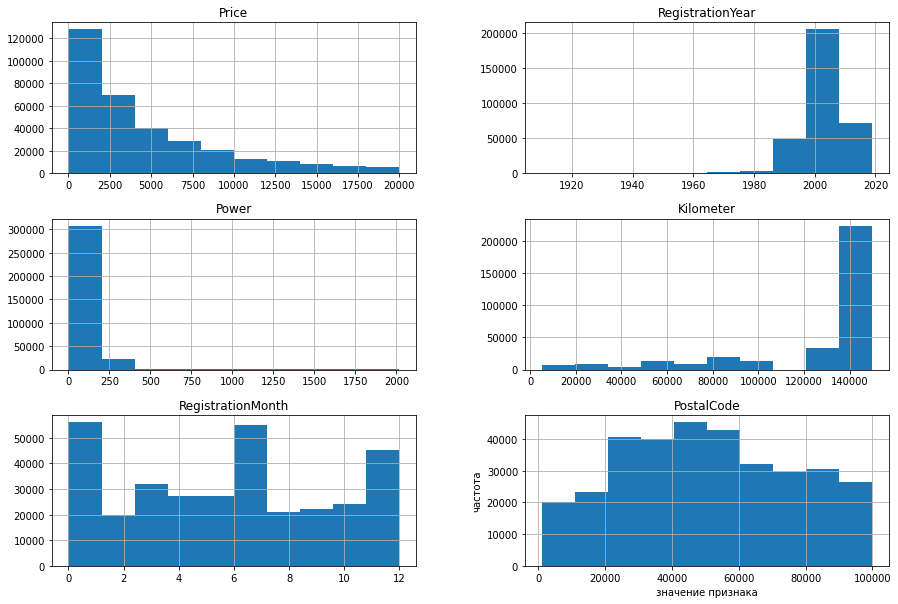

In [ ]:
# построим график для количественных признаков

col_auto = auto[['Price',
                     'RegistrationYear',
                     'Power',
                     'Kilometer',
                    'RegistrationMonth',
                    'PostalCode']]
col_auto.hist(figsize=(15, 10), bins=10)
plt.xlabel('значение признака')
plt.ylabel('частота');

**Итоги по графикам:**

1) `Price` - в столбце много пропусков, в основном цена до 2500 евро

2) `RegistrationYear` - основная часть автомобилей регистрации с 2000 по 2010 годы

3) `Power` - в столбце много пропусков, несмотря на то, что удалили значительную часть

4) `Kilometer` - основная часть автомобилей с пробегом от 120 до 150 тыс км

5) `RegistrationMonth` - месяц регистрации в основном июнь-июль и декабрь, много пропусков - месяц указан 0

6) `PostalCode` - судить о корректности заполнения этого столбца сложно, но по графику распределение нормальное

<span style="text-decoration: underline;">Посмотрим как распределены стоимость автомобиля и характеристики по типу автомобильного кузова, по типу коробки передач и по типу топлива</span>

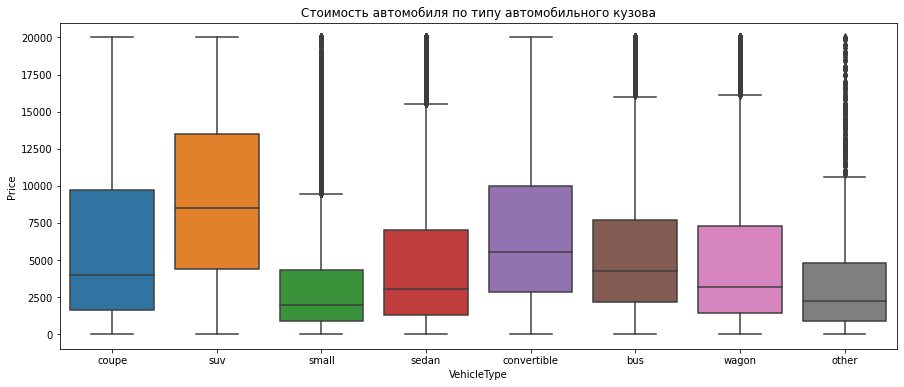

In [ ]:
# построим график "ящик с усами" по типу автомобильного кузова

plt.figure(figsize=(15,6))

plt.title('Стоимость автомобиля по типу автомобильного кузова')
sns.boxplot(x='VehicleType', y = 'Price', data = auto, dodge=False);

**Самые ходовые типы кузовов по количеству представленных авто: suv, coupe, convertible. По медиане схожие по стоимости автомобили с кузовами: coupe, bus, sedan и wagon**

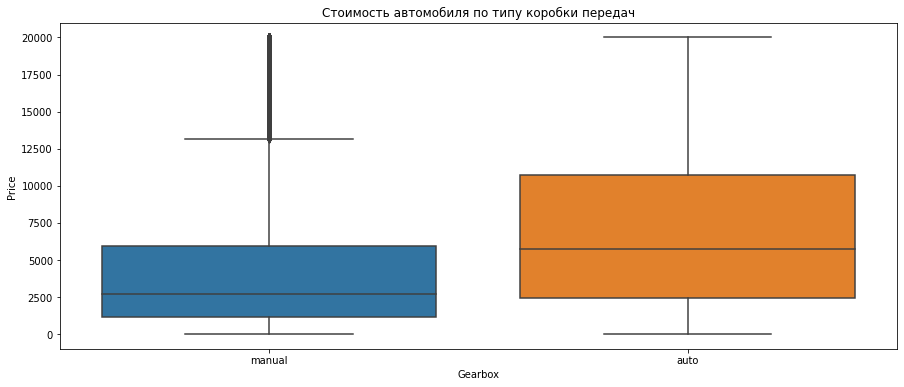

In [ ]:
# построим график "ящик с усами" по типу коробки передач

plt.figure(figsize=(15,6))

plt.title('Стоимость автомобиля по типу коробки передач')
sns.boxplot(x='Gearbox', y = 'Price', data = auto, dodge=False);

**Стоимость автомобилей с автоматической коробкой передач дороже, чем с механической. И диапазон стоимости автомобилей на автомате больше, чем на механике.**

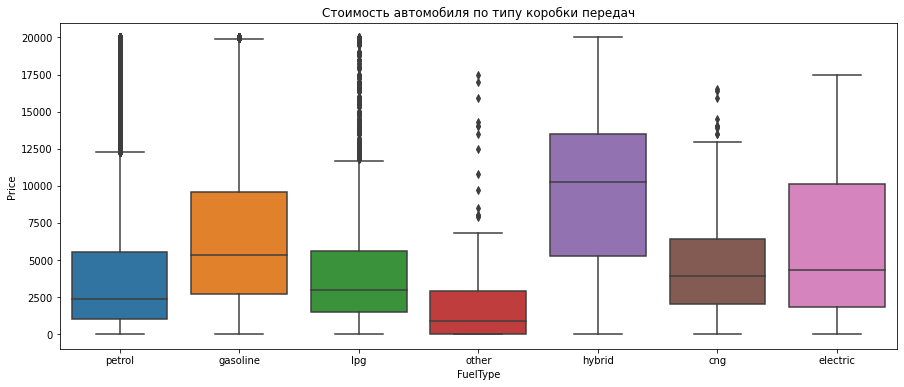

In [ ]:
# построим график "ящик с усами" по типу топлива

plt.figure(figsize=(15,6))

plt.title('Стоимость автомобиля по типу коробки передач')
sns.boxplot(x='FuelType', y = 'Price', data = auto, dodge=False);

**Больше всех представлено автомобилей с гибридом и электических и стоимость их дороже остальных видов топлива. По медиане схожи по стоимости автомобили , которые имеют тип petrol, lpg, cng.**

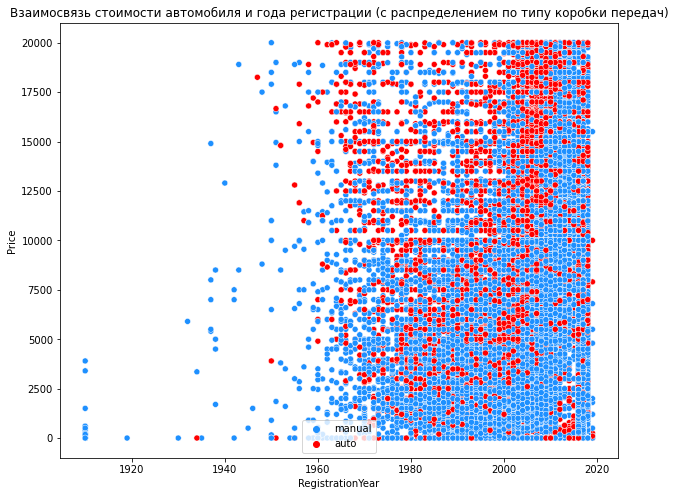

In [ ]:
# посмотрим на диаграмму рассеяния "стоимости и года регистрации"

plt.figure(figsize=(10,8))
sns.scatterplot(data=auto, x = 'RegistrationYear',y= 'Price', hue='Gearbox', palette = ['dodgerblue','red'])
plt.legend(title="", loc=8)
plt.title("Взаимосвязь стоимости автомобиля и года регистрации (с распределением по типу коробки передач)")
plt.show();

**С механической коробкой передач доля автомобилей больше, чем на автоматической. В оснвном год регистрации автомобилей представлен с 1970 по 2019 год. Чем свежее год регистрации автомобиля, тем он дороже.**

**Вцелом можно считать, что автомобили с годом регистрации менее 1960 года являются "выбросами", либо некорректным годом. На графике их количество небольшое, поэтому можно посмотреть их подробнее и при необходимости удалить эти строки**

In [ ]:
# автомобили с регистрацией менее 1960 года

auto_reg = auto.query('RegistrationYear <= 1960')
display(auto_reg['RegistrationYear'].value_counts())

1960    147
1910    100
1956     19
1958     18
1959     16
1950     14
1955     10
1957      9
1951      8
1953      8
1937      7
1952      7
1938      4
1954      3
1942      3
1943      3
1934      3
1929      3
1948      3
1936      2
1935      2
1933      2
1932      2
1947      2
1919      1
1949      1
1946      1
1945      1
1920      1
1915      1
1941      1
1940      1
1930      1
1928      1
1925      1
1944      1
Name: RegistrationYear, dtype: int64

In [ ]:
auto_reg.shape

(407, 15)

In [ ]:
# таких данных 407 строк, удалим их из датасета, так как они нерепрезентативны

auto = auto.query('RegistrationYear > 1960')
auto.shape

(330132, 15)

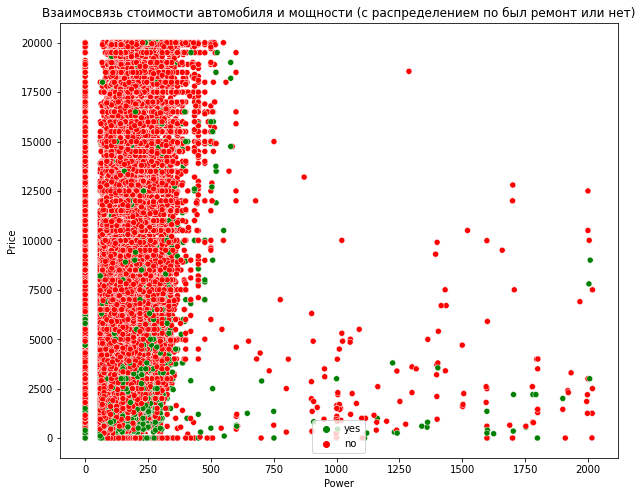

In [ ]:
# посмотрим на диаграмму рассеяния "стоимости и мощности"

plt.figure(figsize=(10,8))
sns.scatterplot(data=auto, x = 'Power',y= 'Price', hue='Repaired', palette=['green','red'])
plt.legend(title="", loc=8)
plt.title("Взаимосвязь стоимости автомобиля и мощности (с распределением по был ремонт или нет)")
plt.show();

**Основная часть автомобилей с мощностью до 500 л.с. Остальные автомобили с мощность более 500 л.с., очевидно являются "выбросами". Сделаем допущение  и посмотрим на автомобили с мощностью более 750 л.с. Возможно, эти данные также можно исключить, если их количество не велико**

In [ ]:
# автомобили с мощностью более 750 л.с.

auto_pow = auto.query('Power >= 750')
display(auto_pow['Power'].value_counts())

1598    8
1800    6
1400    6
1001    6
1600    4
       ..
1111    1
1689    1
850     1
1105    1
901     1
Name: Power, Length: 150, dtype: int64

In [ ]:
auto_pow.shape

(231, 15)

In [ ]:
# как и предполагалось таких автомобилей немного на 231 строку, удалим их из датасета, так как они нерепрезентативны

auto = auto.query('Power < 750')
auto.shape

(329901, 15)

### Корреляционный анализ

Для проведения корреляционного анализа используем библиотеку phik для подсчёта корреляции между признаками разных типов данных

In [ ]:
# создаём список с наименованиями непрерывных признаков

interval_cols = ['Price',
                 'RegistrationYear',
                 'Power',
                 'Kilometer',
                 'RegistrationMonth',
                 'PostalCode']

In [ ]:
# вычисление коэффициентов корреляции phi для датафрейма df

phik_overview = auto.phik_matrix(interval_cols=interval_cols)

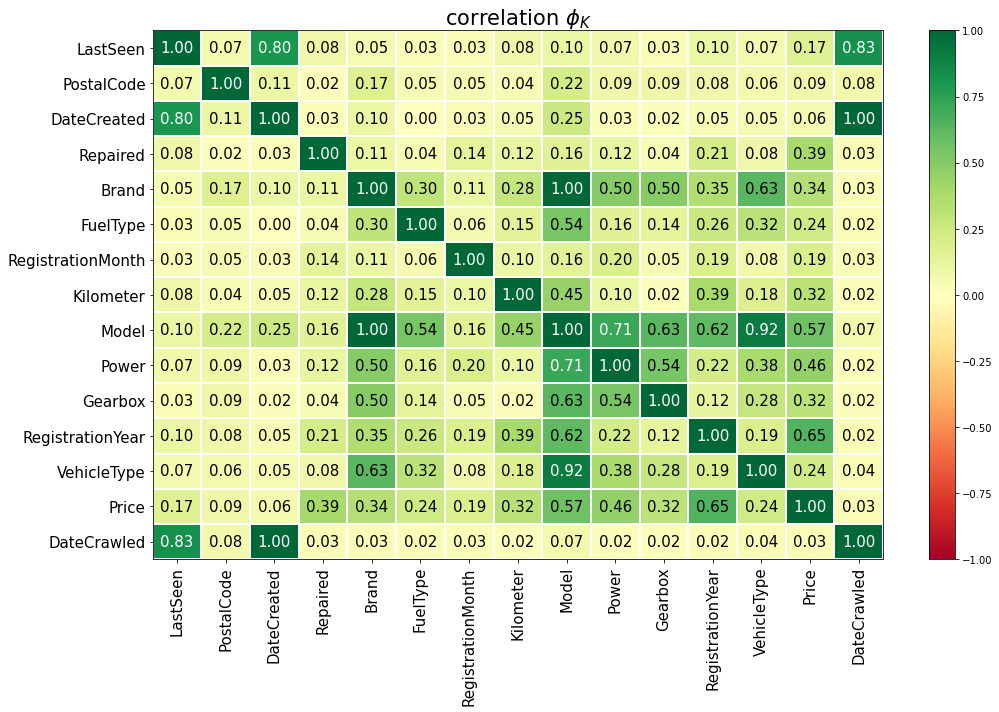

In [ ]:
# визуализация тепловой карты коэффициентов корреляции

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 10))

**Корреляция:**

Высокая корреляция =1 между показателями DateCreated и DateCrawled - один из этих показателей удалим, чтобы модель в дальнейшем корректно работала. Brand и Model также имеют корреляцию = 1, но удалять один из признаков не стоит, так как это может влиять на наш целевой признак.

0,8 - 0,92 между признаками: LastSeen и DateCreated, LastSeen и DateCrawled, Model и VehicleType.

Средняя корреляция 0,5 - 0,7 между признаками: Brand и VehicleType, Model и Power, Model и Gearbox, Model и RegistrationYear, Price и Model и RegistrationYear.

In [ ]:
# так как есть высокая корреляция между датами, то оставим только одну дату
# в датасете - это будет DateCreated (дата создания анкеты)
# остальные столбцы с датами удалим - LastSeen и DateCrawled

auto.drop(['LastSeen', 'DateCrawled'], axis=1, inplace = True)
display(auto.head(2))

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954


In [ ]:
auto.shape

(329901, 13)

**Вывод:**

-- Проведен статистический анализ данных: Так как данные были ранее "почищены" от некорректных значений, то сейчас в глаза бросаются только 0 в столбцах с минимальными значениями. Их мы отработаем на дальнейших шагах в пайплайне.

-- Проведена оценка распределения количественных показателй на графиках:

    * в некоторых столбцах имеются пропущенные значения, которые составляют значительное количество строк.
    * Самые ходовые типы кузовов по количеству представленных авто: suv, coupe, convertible. По медиане схожие по стоимости автомобили с кузовами: coupe, bus, sedan и wagon
    * Стоимость автомобилей с автоматической коробкой передач дороже, чем с механической. И доля автомобилей на автомате больше, чем на механике.
    * Больше всех представлено автомобилей с гибридом и электических и стоимость их дороже остальных видов топлива. По медиане схожи по стоимости автомобили , которые имеют тип petrol, lpg, cng.
    * С помощью диаграмм рассеяния было удалено в общей сложности еще 638 строк, так как эти данные являлись "выбросами"

-- Проведен коррелиционный анализ, который выявил сильную прямую зависимость между признаками и было принято решение удалить столбцы: LastSeen и DateCrawled

## Обучение моделей

### Создание пайплайнов

In [ ]:
# зададим константы

RANDOM_STATE = 55

In [ ]:
# определим целевой показатель

X = auto.drop(columns=['Price', 'DateCreated'], axis=1)
y = auto['Price']

**Разделение данных на обучающую и валидационную выборки в соотношении 75:25**

In [ ]:
X_train,  X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
# сформируем списки для кодирования признаков

# категориальные
ohe_columns = ['Gearbox',
               'Repaired']

# ранговые
ord_columns = ['VehicleType',
               'Model',
              'FuelType',
              'Brand'
              ]

# количественные
num_columns = ['RegistrationYear',
               'Power',
               'Kilometer',
              'RegistrationMonth',
              'PostalCode']

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns
# SimpleImputer + OHE

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))])

In [ ]:
# создаём пайплайн для подготовки признаков из списка ord_columns
# SimpleImputer + ORD + SimpleImputer

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(categories=[
                    ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon'],
                    ['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester',
       'forfour', 'fortwo', 'fox', 'freelander', 'fusion', 'g_klasse',
       'galant', 'galaxy', 'getz', 'gl', 'glk', 'golf', 'grand', 'i3',
       'i_reihe', 'ibiza', 'impreza', 'insignia', 'jazz', 'jetta',
       'jimny', 'juke', 'justy', 'ka', 'kadett', 'kaefer', 'kalina',
       'kalos', 'kangoo', 'kappa', 'kuga', 'laguna', 'lancer', 'lanos',
       'legacy', 'leon', 'lodgy', 'logan', 'lupo', 'lybra', 'm_klasse',
       'm_reihe', 'materia', 'matiz', 'megane', 'meriva', 'micra', 'mii',
       'modus', 'mondeo', 'move', 'musa', 'mustang', 'mx_reihe', 'navara',
       'niva', 'note', 'nubira', 'octavia', 'omega', 'one', 'other',
       'outlander', 'pajero', 'panda', 'passat', 'phaeton', 'picanto',
       'polo', 'primera', 'ptcruiser', 'punto', 'q3', 'q5', 'q7',
       'qashqai', 'r19', 'range_rover', 'range_rover_evoque',
       'range_rover_sport', 'rangerover', 'rav', 'rio', 'roadster',
       'roomster', 'rx_reihe', 's60', 's_klasse', 's_max', 's_type',
       'samara', 'sandero', 'santa', 'scenic', 'scirocco', 'seicento',
       'serie_1', 'serie_2', 'serie_3', 'sharan', 'signum', 'sirion',
       'sl', 'slk', 'sorento', 'spark', 'spider', 'sportage', 'sprinter',
       'stilo', 'superb', 'swift', 'terios', 'tigra', 'tiguan', 'toledo',
       'touareg', 'touran', 'transit', 'transporter', 'tt', 'tucson',
       'twingo', 'up', 'v40', 'v50', 'v60', 'v70', 'v_klasse', 'vectra',
       'verso', 'viano', 'vito', 'vivaro', 'voyager', 'wrangler',
       'x_reihe', 'x_trail', 'x_type', 'xc_reihe', 'yaris', 'yeti',
       'ypsilon', 'z_reihe', 'zafira'],
                    ['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol'],
                    ['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo']
        ],
                handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

#

In [ ]:
# подготовка общего пайплайна для подготовки данных
# preprocessor__num = preprocessor_ + _num:
# preprocessor__num — пайплайн, в котором находится шаг масштабирования
# num — шаг масштабирования с методом и списком столбцов
# заодно укажем 'passthrough' — вариант без масштабирования

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель

#pipe_final = Pipeline([
#    ('preprocessor', data_preprocessor) #,
    #('models', LinearRegression())
#])

In [ ]:
# убираем ошибки из-за возможно устаревшей версии sklearn

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Обучение моделей

Для работы нам понадобятся модели регрессии, так как целевой признак непрерывное значение.

Для автоматического подбора гиперпараметров будем использовать инструмент GridSearchCV.

models — инициализированная модель

param_grid — словарь с гиперпараметрами модели

cv — тип кросс-валидации

scoring — метрика, которую используем для выбора лучшего решения

n_jobs=-1 — подключаем к расчёту ядра процессора

**Значение метрики RMSE должно быть меньше 2500**

#### ЛИНЕЙНАЯ РЕГРЕССИЯ

In [ ]:
# cоздадим с помощью класса make_pipeline объект-контейнер, в который поместим необходимые нам инструменты

regress_model = make_pipeline(data_preprocessor,
                              LinearRegression(normalize = False,
                            fit_intercept = True,
                            copy_X=True)) # линейная регрессия

# определим параметры для моделей

parameter_regress = {} # линейная регрессия

# используем инструмент GridSearchCV для автоматического подбора параметров для моделей машинного обучения

grid_regress = GridSearchCV(regress_model,
                                    param_grid=parameter_regress,
                                    #cv=5,
                                    scoring='neg_mean_absolute_error',
                                    verbose=1,
                                    n_jobs=-1)



In [ ]:
# %%time
# время обучения на тренировочной выборке

# обучение моделей

grid_regress.fit(X_train, y_train)

# выведем лучшие параметры

print('Лучшие параметры модели:\n\n', grid_regress.best_estimator_)
print()
print ('RMSE лучшей модели Линейной регрессии:', abs(grid_regress.best_score_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Лучшие параметры модели:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                  

In [ ]:
# Сохраняем лучшую модель в новую переменную

best_model_regress = grid_regress.best_estimator_

In [ ]:
%%time
# Замеряем время обучения у лучшей модели

best_model_regress.fit(X_train, y_train)

CPU times: user 796 ms, sys: 36.1 ms, total: 833 ms
Wall time: 791 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                           

In [ ]:
%%time
# время предсказания на тренировочной выборке

best_model_regress.predict(X_train)

CPU times: user 438 ms, sys: 17 ms, total: 455 ms
Wall time: 442 ms


array([5864.91176049, 3435.38024295, 6016.46328032, ..., 3538.8667822 ,
       -503.41552241, 2728.17488232])

#### ДЕРЕВО РЕШЕНИЙ

In [ ]:
# cоздадим с помощью класса make_pipeline объект-контейнер, в который поместим необходимые нам инструменты

tree_model = make_pipeline(data_preprocessor, DecisionTreeRegressor()) # дерево решений

# определим параметры для моделей

parameter_tree = {'decisiontreeregressor__max_depth':range(1,5),
                 'decisiontreeregressor__max_features': range(1,5),
                 'decisiontreeregressor__random_state' : [RANDOM_STATE]} # дерево решений

# используем инструмент GridSearchCV для автоматического подбора параметров для моделей машинного обучения

grid_tree = GridSearchCV(tree_model,
                                 param_grid=parameter_tree,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 verbose=1)



In [ ]:
# %%time
# время обучения на тренировочной выборке

# обучение моделей

grid_tree.fit(X_train, y_train)

# выведем лучшие параметры

print('Лучшие параметры модели:\n\n', grid_tree.best_estimator_)
print()
print ('RMSE лучшей модели Дерева решений:', abs(grid_tree.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры модели:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                

In [ ]:
# Сохраняем лучшую модель в новую переменную

best_model_tree = grid_tree.best_estimator_

In [ ]:
%%time
# Замеряем время обучения у лучшей модели

best_model_tree.fit(X_train, y_train)

CPU times: user 831 ms, sys: 28 ms, total: 859 ms
Wall time: 858 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                           

In [ ]:
%%time
# время предсказания на тренировочной выборке

best_model_tree.predict(X_train)

CPU times: user 431 ms, sys: 32.1 ms, total: 463 ms
Wall time: 461 ms


array([8149.48775689, 2121.26377377, 4060.77301438, ..., 1656.90773052,
       1656.90773052, 3120.0966567 ])

#### LightGBM - ГРАДИЕНТНЫЙ БУСТИНГ

In [ ]:
# cоздадим с помощью класса make_pipeline объект-контейнер, в который поместим необходимые нам инструменты

light_model = make_pipeline(data_preprocessor, lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE))

# определим параметры для моделей

parameter_light = {'lgbmregressor__learning_rate':[0.1, 0.5],
                 'lgbmregressor__max_depth': range(1,5),
                 'lgbmregressor__n_estimators' : range(50, 100, 50)}

# используем инструмент GridSearchCV для автоматического подбора параметров для моделей машинного обучения

grid_light = GridSearchCV(light_model,
                                 param_grid=parameter_light,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 verbose=1)



In [ ]:
# %%time
# время обучения на тренировочной выборке

# обучение моделей

grid_light.fit(X_train, y_train)

# выведем лучшие параметры

print('Лучшие параметры модели:\n\n', grid_light.best_estimator_)
print()
print ('RMSE лучшей модели LightGBM:', abs(grid_light.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры модели:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                 

In [ ]:
# Сохраняем лучшую модель в новую переменную

best_model_light = grid_light.best_estimator_

In [ ]:
%%time
# Замеряем время обучения у лучшей модели

best_model_light.fit(X_train, y_train)

CPU times: user 3.73 s, sys: 68.4 ms, total: 3.8 s
Wall time: 3.8 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Gearbox', 'Repaired']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                           

In [ ]:
%%time
# время предсказания на тренировочной выборке

best_model_light.predict(X_train)

CPU times: user 1.23 s, sys: 31.1 ms, total: 1.26 s
Wall time: 1.25 s


array([5352.92775966, 2205.90642759, 4261.54374416, ..., 1141.59448312,
        952.33277311,  432.38773381])

####  CatBoost - ГРАДИЕНТНЫЙ БУСТИНГ

In [ ]:
# cоздадим с помощью класса make_pipeline объект-контейнер, в который поместим необходимые нам инструменты

cat_model = make_pipeline(data_preprocessor, CatBoostRegressor(random_state=RANDOM_STATE))

# определим параметры для моделей

parameter_cat = {'catboostregressor__learning_rate':[0.1, 0.5],
                 'catboostregressor__max_depth': range(1,5),
                 'catboostregressor__n_estimators' : range(50, 100, 50)
                }

# используем инструмент GridSearchCV для автоматического подбора параметров для моделей машинного обучения

grid_cat = GridSearchCV(cat_model,
                                 param_grid=parameter_cat,
                                 cv=5,
                                 scoring='neg_mean_absolute_error',
                                 n_jobs=-1,
                                 verbose=0)



In [ ]:
# %%time
# время обучения на тренировочной выборке

# обучение моделей

grid_cat.fit(X_train, y_train)

# выведем лучшие параметры

print('Лучшие параметры модели:\n\n', grid_cat.best_estimator_)
print()
print ('RMSE лучшей модели CatBoost:', abs(grid_cat.best_score_))

0:	learn: 4444.6193146	total: 70.6ms	remaining: 3.46s
1:	learn: 4335.4951410	total: 87.8ms	remaining: 2.11s
2:	learn: 4242.4110114	total: 108ms	remaining: 1.69s
3:	learn: 4158.5807933	total: 125ms	remaining: 1.43s
4:	learn: 4079.8550987	total: 141ms	remaining: 1.27s
5:	learn: 4011.4800539	total: 159ms	remaining: 1.16s
6:	learn: 3946.0771265	total: 176ms	remaining: 1.08s
7:	learn: 3887.4042052	total: 194ms	remaining: 1.02s
8:	learn: 3832.2632338	total: 211ms	remaining: 961ms
9:	learn: 3782.2450187	total: 228ms	remaining: 913ms
10:	learn: 3735.8859983	total: 244ms	remaining: 867ms
11:	learn: 3692.1440172	total: 261ms	remaining: 826ms
12:	learn: 3652.8113321	total: 276ms	remaining: 787ms
13:	learn: 3615.2747463	total: 296ms	remaining: 761ms
14:	learn: 3577.0488954	total: 312ms	remaining: 727ms
15:	learn: 3544.1094144	total: 327ms	remaining: 695ms
16:	learn: 3511.6284265	total: 342ms	remaining: 664ms
17:	learn: 3481.8957606	total: 358ms	remaining: 636ms
18:	learn: 3452.7815568	total: 373ms

In [ ]:
# Сохраняем лучшую модель в новую переменную

best_model_cat = grid_cat.best_estimator_

In [ ]:
%%time
# время предсказания на тренировочной выборке

best_model_cat.predict(X_train)

CPU times: user 1.11 s, sys: 39.6 ms, total: 1.15 s
Wall time: 1.15 s


array([4823.71508185, 1828.12492019, 4320.98053262, ..., 1816.37985772,
        843.2033923 ,  880.79045537])

In [ ]:
%%time
# время предсказания на тренировочной выборке

best_model_cat.predict(X_train)

CPU times: user 1.09 s, sys: 31.9 ms, total: 1.12 s
Wall time: 1.12 s


array([4823.71508185, 1828.12492019, 4320.98053262, ..., 1816.37985772,
        843.2033923 ,  880.79045537])

**Вывод:**

* Для обучения моделей был создан пайплайн для обработки категориальных значений и масштабирования количественных признаков

* Было обучено 4 модели: LinearRegression, DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor с подбором гиперпараметров через GridSearchCV

* RMSE тренировочной выборки лучшей модели Линейной регрессии: 2305

* RMSE тренировочной выборки лучшей модели Дерева решений: 2151

* RMSE тренировочной выборки лучшей модели LightGBM: 1235

* RMSE тренировочной выборки лучшей модели CatBoost: 1285

## Анализ моделей

In [ ]:
# создаем таблицу с данными для сравнения всех моделей

dict = {'model': ['LinearRegression'],
        'RMSE_train': round(abs(grid_regress.best_score_),2),
        'Wall time fit': '791 ms ms',
        'Wall time predict': '442 ms',
        'RMSE_test': '',
        'Wall time test': ''
        }
results = pd.DataFrame(dict)

display(results)

,model,RMSE_train,Wall time fit,Wall time predict,RMSE_test,Wall time test
0,LinearRegression,2305.52,791 ms ms,442 ms,,


In [ ]:
# добавим все метрики в одну таблицу

results.loc[len(results.index)] = ['DecisionTreeRegressor', round(abs(grid_tree.best_score_),2), '858 ms', '461 ms', '', '']
results.loc[len(results.index)] = ['LGBMRegressor', round(abs(grid_light.best_score_),2), '3.8 s','1.25 s', '' , '']
results.loc[len(results.index)] = ['CatBoostRegressor', round(abs(grid_cat.best_score_),2), ' 1.15 s','1.12 s', '', '']

display(results)

,model,RMSE_train,Wall time fit,Wall time predict,RMSE_test,Wall time test
0,LinearRegression,2305.52,791 ms ms,442 ms,,
1,DecisionTreeRegressor,2151.79,858 ms,461 ms,,
2,LGBMRegressor,1235.35,3.8 s,1.25 s,,
3,CatBoostRegressor,1285.27,1.15 s,1.12 s,,


По итогам работы 4 моделей наилучшую метрику на тренировочной выборке показала модель **LGBMRegressor	RMSE = 1235.35**

In [ ]:
%%time

# замеряем время предсказания LightGBM

predict_light = grid_light.best_estimator_.predict(X_test)

print(f'RMSE LightGBM на тестовой выборке: {mean_squared_error(y_test, predict_light, squared=False)}')

RMSE LightGBM на тестовой выборке: 1972.208488984085
CPU times: user 407 ms, sys: 10.7 ms, total: 417 ms
Wall time: 339 ms


In [ ]:
results.loc[len(results.index)] = ['LGBMRegressor', round(abs(grid_light.best_score_),2), '3.8 s','1.25 s',round(mean_squared_error(y_test, predict_light, squared=False),2) , '339 ms']

display(results)

,model,RMSE_train,Wall time fit,Wall time predict,RMSE_test,Wall time test
0,LinearRegression,2305.52,791 ms ms,442 ms,,
1,DecisionTreeRegressor,2151.79,858 ms,461 ms,,
2,LGBMRegressor,1235.35,3.8 s,1.25 s,,
3,CatBoostRegressor,1285.27,1.15 s,1.12 s,,
4,LGBMRegressor,1235.35,3.8 s,1.25 s,1972.21,339 ms


## Общий вывод по проекту

**1)** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» предоставили датасет для построения модели для оценки рыночной стоимости автомобилей . В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

При подборе модели необходимо выполнить условие: Значение метрики RMSE должно быть меньше 2500

**2)** Была проведена предобработка данных в части проверки на наличие пропусков и дубликатов. По итогам анализа данных, датасет был очищен от некорректных значений, было удалено порядка 7% строк, что является допустимым при таком объеме данных.

**3)** Был проведен исследовательский анализ данных - статистический, графический, корреляционный анализ по итогам которого сформировали следующие выводы:

* Самые ходовые типы кузовов по количеству представленных авто: suv, coupe, convertible. По медиане схожие по стоимости автомобили с кузовами: coupe, bus, sedan и wagon

* Стоимость автомобилей с автоматической коробкой передач дороже, чем с механической. И доля автомобилей на автомате больше, чем на механике.

* Больше всех представлено автомобилей с гибридом и электических и стоимость их дороже остальных видов топлива. По медиане схожи по стоимости автомобили , которые имеют тип petrol, lpg, cng.

* С помощью диаграмм рассеяния было удалено в общей сложности еще 638 строк, так как эти данные являлись "выбросами"

* Высокая корреляция 0,8 - 0,92 между признаками: LastSeen и DateCreated, LastSeen и DateCrawled, Model и VehicleType.

* Средняя корреляция 0,5 - 0,7 между признаками: Brand и VehicleType, Model и Power, Model и Gearbox, Model и RegistrationYear, Price и Model и RegistrationYear.

**4)** Для обучения моделей был создан пайплайн для обработки категориальных значений и масштабирования количественных признаков

* Было обучено 4 модели: LinearRegression, DecisionTreeRegressor, LGBMRegressor, CatBoostRegressor с подбором гиперпараметров через GridSearchCV

* RMSE тренировочной выборки лучшей модели Линейной регрессии: 2305

* RMSE тренировочной выборки лучшей модели Дерева решений: 2151

* RMSE тренировочной выборки лучшей модели LightGBM: 1235

* RMSE тренировочной выборки лучшей модели CatBoost: 1285

**5)** Анализ моделей на тестовых данных показал следующие результаты:


In [ ]:
display(results.sort_values(by=['RMSE_train'], ascending = True ))

,model,RMSE_train,Wall time train,Wall time predict,RMSE_test,Wall time test
2,LGBMRegressor,1235.35,1min 58s,1.04 s,,
4,LGBMRegressor,1235.35,1min 58s,1.04 s,1972.21,330 ms
3,CatBoostRegressor,1285.27,1min 56s,1.1 s,,
1,DecisionTreeRegressor,2151.79,58.4 s,448 ms,,
0,LinearRegression,2305.52,5.78 s,429 ms,,


**Лучшая модель на тестовой выборке по RMSE - LGBMRegressor RMSE_test = 1972.21**

Условие - Значение метрики RMSE должно быть меньше 2500 - выполнено.

# Спасибо за внимание!